In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.linear_model import *
from sklearn.multioutput import *
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

2024-09-26 13:09:00.267205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 13:09:00.354000: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
jfunc_all_data = xr.load_dataset("./data/jfunction_data_med.nc")
jfunc_all_data

<xarray.Dataset>
Dimensions:                 (Radius: 180, Monte Carlo Simulation: 9895,
                             class: 3, y: 1)
Coordinates:
  * Radius                  (Radius) float64 0.0 0.01676 0.03352 ... 2.983 3.0
  * Monte Carlo Simulation  (Monte Carlo Simulation) float64 1.0 ... 9.895e+03
  * class                   (class) int64 0 1 2
Dimensions without coordinates: y
Data variables:
    v                       (class, Monte Carlo Simulation, y, Radius) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    contact:      Niklas.luther@zeu.uni-giessen.de
    history:      Wed Sep 18 15:48:58 2024: cdo mermean Process=hardcore_INTE...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [3]:
X_raw = jfunc_all_data.v.to_numpy()
X_raw.shape

(3, 9895, 1, 180)

In [4]:
X_raw_0 = X_raw[0, ~np.any(np.isnan(X_raw[0]), axis=(1,2))]
X_raw_1 = X_raw[1, ~np.any(np.isnan(X_raw[1]), axis=(1,2))]
X_raw_2 = X_raw[2, ~np.any(np.isnan(X_raw[2]), axis=(1,2))]
X_raw_0.shape, X_raw_1.shape, X_raw_2.shape

((7883, 1, 180), (5362, 1, 180), (9895, 1, 180))

(23140, 180, 1)
[[0]
 [0]
 [0]
 ...
 [2]
 [2]
 [2]]
[array([0, 1, 2])]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

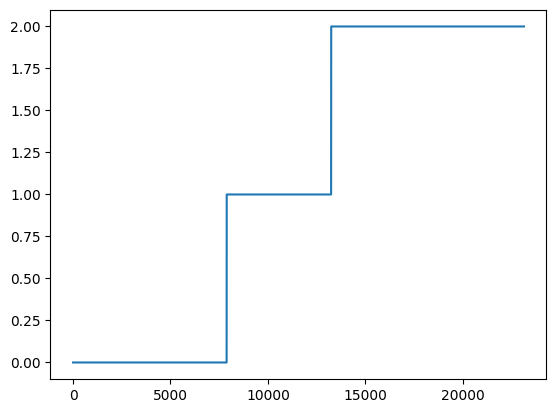

In [5]:
X = np.concatenate([X_raw_0, X_raw_1, X_raw_2])
X = X.transpose((0,2,1))
print(X.shape)

y_base = np.concatenate([np.zeros(X_raw_0.shape[0], dtype=int), np.ones(X_raw_1.shape[0], dtype=int), np.full(X_raw_2.shape[0], 2)]).reshape((-1, 1))
# oh_enc = OneHotEncoder(categories=[0,1,2], sparse_output=False, handle_unknown='infrequent_if_exist')
oh_enc = OneHotEncoder(sparse_output=False)
# oh_enc = oh_enc.fit(y_base.squeeze())
print(y_base)
y = oh_enc.fit_transform(y_base)
print(oh_enc.categories_)
plt.plot(y_base)
y

In [6]:
points_avobe = X[:,1:,:] > 1
points_below = X[:,1:,:] < 1
perc_avobe = np.sum(points_avobe, axis=1).squeeze()/points_avobe.shape[1]
perc_below = np.sum(points_below, axis=1).squeeze()/points_below.shape[1]
print(perc_avobe, perc_avobe.min(), perc_avobe.max())
print(perc_below, perc_below.min(), perc_below.max())

X_added = np.stack([perc_avobe, perc_below], axis=1)
X_added, X_added.shape

[1.         1.         1.         ... 1.         0.         0.45810056] 0.0 1.0
[0.         0.         0.         ... 0.         1.         0.54189944] 0.0 1.0


(array([[1.        , 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [1.        , 0.        ],
        [0.        , 1.        ],
        [0.45810056, 0.54189944]]),
 (23140, 2))

In [7]:
X_grad = np.diff(X, axis=1)
X_grad, X_grad.shape

(array([[[ 0.0049324 ],
         [ 0.00465763],
         [ 0.00456226],
         ...,
         [ 0.04688215],
         [ 0.04480743],
         [ 0.05107117]],
 
        [[ 0.00445032],
         [ 0.00436306],
         [ 0.00428951],
         ...,
         [ 0.02150536],
         [ 0.02153325],
         [ 0.02117658]],
 
        [[ 0.00631511],
         [ 0.00598264],
         [ 0.00607955],
         ...,
         [ 0.02358103],
         [ 0.01886272],
         [ 0.01609135]],
 
        ...,
 
        [[ 0.00206137],
         [ 0.00151324],
         [ 0.0001322 ],
         ...,
         [ 0.00380909],
         [ 0.00643647],
         [ 0.00251234]],
 
        [[-0.00279772],
         [-0.0025537 ],
         [-0.001885  ],
         ...,
         [ 0.00070149],
         [ 0.00071716],
         [-0.00170833]],
 
        [[-0.0008927 ],
         [ 0.00024563],
         [ 0.00080884],
         ...,
         [ 0.00156069],
         [ 0.00326216],
         [ 0.00247002]]], dtype=float32),
 (23

In [8]:
# X_train_base, X_test_base, X_train_added, X_test_added, y_train, y_test, y_train_base, y_test_base = train_test_split(X, X_added, y, y_base, test_size=0.2, shuffle=True, random_state=0)
X_train_base, X_test_base, X_train_added, X_test_added, X_train_grad, X_test_grad, y_train, y_test, y_train_base, y_test_base = \
    train_test_split(X, X_added, X_grad, y, y_base, test_size=0.2, shuffle=True, random_state=0)
print(X_train_base.shape)
print(X_test_base.shape)

abs_max = np.abs(X_train_base - 1).max()

X_train = (X_train_base - 1)/abs_max
X_test = (X_test_base - 1)/abs_max

abs_max_grad = np.abs(X_train_grad).max()

X_train_grad = (X_train_grad - 1)/abs_max_grad
X_test_grad = (X_test_grad - 1)/abs_max_grad

# X_scaler = StandardScaler()
# X_train = X_scaler.fit_transform(X_train_base.reshape((-1, 1))).reshape(X_train_base.shape)
# X_test = X_scaler.transform(X_test_base.reshape((-1, 1))).reshape(X_test_base.shape)

(18512, 180, 1)
(4628, 180, 1)


In [19]:
x_input = keras.Input(X.shape[1:])
x = x_input
x = keras.layers.Conv1D(64, 5, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Conv1D(32, 5, padding="same", activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Flatten()(x)


# x_input_grad = keras.Input(X_grad.shape[1:])
# x_grad = x_input_grad
# x_grad = keras.layers.Conv1D(64, 5, padding="same", activation='relu')(x_grad)
# x_grad = keras.layers.MaxPooling1D()(x_grad)
# x_grad = keras.layers.Conv1D(32, 5, padding="same", activation='relu')(x_grad)
# x_grad = keras.layers.MaxPooling1D()(x_grad)
# x_grad = keras.layers.Flatten()(x_grad)

x = keras.layers.Concatenate(axis=1)([x, x_grad])

x = keras.layers.Dense(3, activation='softmax')(x)
x = keras.layers.Concatenate(axis=1)([x, x_grad])
x = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model([x_input, x_input_grad], x)
# model = keras.Model(x_input, x)


# optimizer = keras.optimizers.Adam(1e-4)
optimizer = keras.optimizers.RMSprop(5e-5)
model.compile(optimizer=optimizer, loss="bce")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 180, 1)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 179, 1)]     0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 180, 64)      384         ['input_12[0][0]']               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 179, 64)      384         ['input_11[0][0]']               
                                                                                            

In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
# history = model.fit(X_train, y_train, epochs=100, validation_split=0.15, callbacks)
# history = model.fit([X_train, X_added], y_train, epochs=100, validation_split=0.15)
# history = model.fit(X_train_grad, y_train, epochs=5000, validation_split=0.15, callbacks=[early_stopping])
history = model.fit([X_train, X_train_grad], y_train, epochs=5000, validation_split=0.15, callbacks=[early_stopping])

Epoch 1/5000
492/492 [==============================] - 3s 5ms/step - loss: 0.6311 - val_loss: 0.6143
Epoch 2/5000
492/492 [==============================] - 2s 5ms/step - loss: 0.6113 - val_loss: 0.6037
Epoch 3/5000
492/492 [==============================] - 2s 5ms/step - loss: 0.6030 - val_loss: 0.5963
Epoch 4/5000
492/492 [==============================] - 2s 5ms/step - loss: 0.5958 - val_loss: 0.5884
Epoch 5/5000
492/492 [==============================] - 2s 4ms/step - loss: 0.5884 - val_loss: 0.5807
Epoch 6/5000
492/492 [==============================] - 2s 3ms/step - loss: 0.5809 - val_loss: 0.5727
Epoch 7/5000
492/492 [==============================] - 1s 2ms/step - loss: 0.5728 - val_loss: 0.5654
Epoch 8/5000
492/492 [==============================] - 2s 3ms/step - loss: 0.5638 - val_loss: 0.5578
Epoch 9/5000
492/492 [==============================] - 2s 5ms/step - loss: 0.5540 - val_loss: 0.5430
Epoch 10/5000
492/492 [==============================] - 3s 5ms/step - loss: 0.542

In [11]:
# model = LogisticRegression()
# model = MultiOutputClassifier(model)
# model = model.fit(X_train_added, y_train_base)
# model.predict(X_train_added)

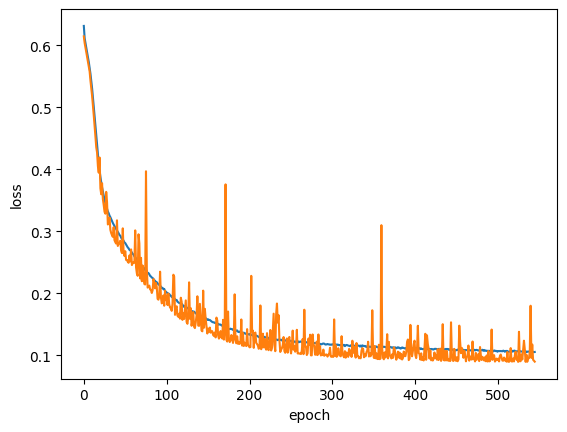

In [23]:
history_curve = history.history
history_curve["epoch"] = list(range(len(history_curve["loss"])))
fig, ax = plt.subplots()
sns.lineplot(history_curve, x="epoch", y="loss", ax=ax)
sns.lineplot(history_curve, x="epoch", y="val_loss", ax=ax)
plt.show()

145/145 [==============================] - 0s 581us/step


[Text(0.5, 1.0, 'Test')]

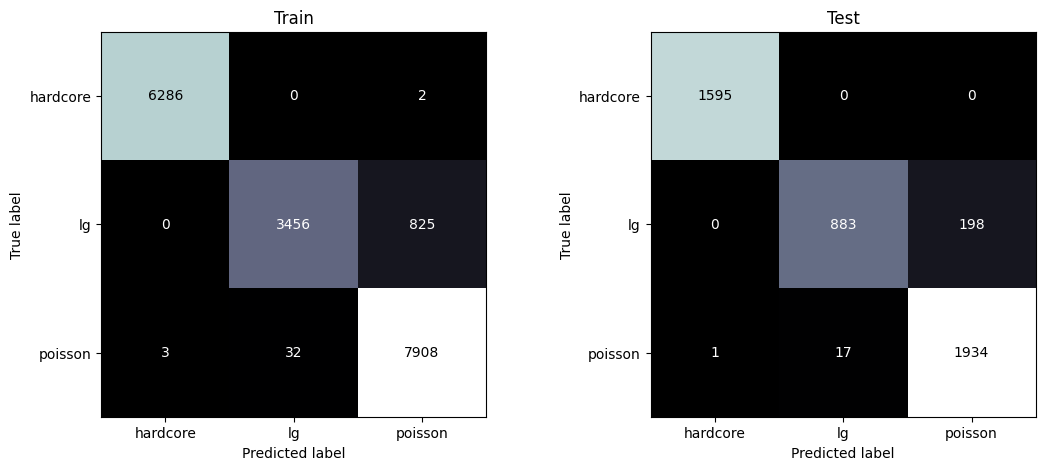

In [25]:
# pred_train = model.predict([X_train, X_train_added])
# pred_train = model.predict(X_train_added)
# pred_train = model.predict(X_train_grad)
pred_train = model.predict([X_train, X_train_grad])
y_train_disp = y_train_base
# pred_train_disp = pred_train
pred_train_disp = oh_enc.inverse_transform(pred_train)

# pred_test = model.predict([X_test, X_test_added])
# pred_test = model.predict(X_test_added)
# pred_test = model.predict(X_test_grad)
pred_test = model.predict([X_test, X_test_grad])
y_test_disp = y_test_base
# pred_test_disp = pred_test
pred_test_disp = oh_enc.inverse_transform(pred_test)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay.from_predictions(y_train_disp, pred_train_disp, ax=ax[0], colorbar=False, cmap="bone", display_labels=["hardcore", "lg", "poisson"])
ax[0].set(title="Train")
ConfusionMatrixDisplay.from_predictions(y_test_disp, pred_test_disp, ax=ax[1], colorbar=False, cmap="bone", display_labels=["hardcore", "lg", "poisson"])
ax[1].set(title="Test")